In [1]:
__author__ = 'Derek Qi'
# Doing portfolio backtest and generates output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time

from setup.univ_setup import *
from factor_mining.combine_factors import *
from factor_mining.factor_model_regression import *

from factor_model.stock_ret_est import GenReturn 
from GenPosition import *
from backtest_main import *

from factor_mining.factors.momentum import *

from factor_mining.Mark0 import * # This is alpha file

In [7]:
# def backtest_single_period(univ, factor_exp_mat, ret_series, t):
# 	'''
# 	Do a single period backtest on univ[t]
# 	t: datetime object that is one of the element in keys of univ
# 	factor_exp_mat, ret_series: factor exposure and return time series
# 	'''
# 	# Set backtest params
# 	lookback = timedelta(weeks=104)
# 	dend = t
# 	dstart = dend - lookback

# 	# Calc stock return
# 	ret_series = momentum(univ, 0, 1)

# 	# Fit single period factor return
# 	fr, fr_mse = factor_model_fit(factor_exp_mat, ret_series, dstart, dend)

# 	fx = factor_exp_mat[dend]
# 	fx = fx.dropna()
# 	# Filt the available pool
# 	univ_fin = univ[dend]
# 	univ_fin = univ_fin.dropna()
# 	# Throw away penny stocks
# 	univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
# 	# Throw away illiquid stocks
# 	univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
# 	# Throwaway those inMA
# 	univ_fin = filt_byval_single_period(univ_fin, 'inMA', 0)
# 	fx = pd.merge(fx, univ_fin[['ticker']], how='inner', on='ticker')
# 	print('Pool size: %d' % fx.shape[0])
# 	# Calculate position
# 	stock_list, w_opt = GenPosition(fr, fx)
# 	w_opt = PositionFilter(w_opt) # filt away very small number in portfolio
# 	ptfl_full = pd.DataFrame({"ticker": stock_list, "weight": list(w_opt.T[0])})
# 	ptfl_full = pd.merge(ptfl_full, univ_fin[['ticker', 'log_ret']], how='inner', on='ticker')
# 	pnl_sp = np.dot(ptfl_full.weight, ptfl_full.log_ret)
# 	print(ptfl_full.ix[ptfl_full['weight'] != 0,:])
# 	return ptfl_full, pnl_sp


# def backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend):
# 	'''
# 	Run backtest in batch to portfolio from dstart to dend
# 	'''
# 	datelst = sorted(univ.keys())
# 	tin_lst, ptfl_lst, pnl_lst = [], [], []
# 	for ti in range(len(datelst)):
# 		t = datelst[ti]
# 		if t < dstart or t > dend:
# 			continue

# 		print(t)
# 		tin_lst.append(t)
# 		ptfl, pnl_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t)
# 		ptfl_lst.append(ptfl)
# 		pnl_lst.append(pnl_sp)


# 	pnl = pd.DataFrame({'date': tin_lst, 'pnl': pnl_lst})
# 	return ptfl_lst[-1], pnl

In [2]:
### universe setup ###
print('Setup R3000 universe')
start = time()
big_table_dir = '/home/derek-qi/Documents/R3000_Data/data/r3000/big_table_full_v2.csv'
univ = univ_setup(big_table_dir)
filt_by_name(univ) # This is fucking slow！
end = time()
print('%f seconds' % end - start)

In [3]:
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
print('Done')

Calculate factors


In [4]:
# const setup
factor_names = [k for k in factors.keys()]
N_f = len(factor_names)
datelst = sorted(factor_exp_mat.keys())
N_T = len(datelst)

# Calc stock returns
ret_series = momentum(univ, 0, 1)

In [26]:
# Run backtest
dstart = datetime(2016, 1, 1)
dend = datetime(2016, 7, 1)
print('Start backtest from %s to %s' % (dstart.strftime('%Y/%m/%d'), dend.strftime('%Y/%m/%d')))
ts = time()
ptfl_fin, pnl = backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=False)
te = time()
print(te - ts)

Start backtest from 2016/01/01 to 2016/07/01
2016-01-01 00:00:00
Pool size: 603
    ticker  weight   log_ret
10    ADXS     0.1 -0.236654
20    AKBA     0.1 -0.417535
81     BZH     0.1 -0.166263
137    CRR     0.1 -0.067955
323     LL     0.1 -0.236043
368   NHTC     0.1 -0.361843
375   NPTN     0.1 -0.213750
542   TTPH     0.1 -0.338468
588   YRCW     0.1 -0.151217
589   ZAGG     0.1 -0.123397
Period log pnl: -0.231313
2016-01-08 00:00:00
Pool size: 891
    ticker  weight   log_ret
4     AAOI     0.1 -0.097205
54    ARDX     0.1 -0.015985
69     AVD     0.1  0.000971
84     BBW     0.1  0.139842
107   BOOT     0.1 -0.362605
226   DFRG     0.1  0.060058
439   KIRK     0.1 -0.051792
533   NHTC     0.1 -0.274215
696   SCHN     0.1 -0.056882
870   ZGNX     0.1 -0.041925
Period log pnl: -0.069974
2016-01-15 00:00:00
Pool size: 899
    ticker  weight   log_ret
9     ACAT     0.1 -0.034280
88     BBW     0.1  0.030747
94    BGFV     0.1 -0.063052
160   CHMA     0.1 -0.268202
223   CWEI     

In [19]:
# def GenPortfolioReport(ptfl_full, report_file, pt=False):
#     # Generates the portfolio report, fetch data from Yahoo finance
#     ptfl_sel = ptfl_full[ptfl_full['weight'] != 0]

#     ticker_list = list(ptfl_sel['ticker'])

#     row_dict_list = []
#     # get Name, prev_close, market_cap, PE, avg_daily_volume, from Yahoo finance
#     for ticker in ticker_list:
#         stock = Share(ticker)
#         stock.refresh()

#         name = stock.get_name()
#         prev_close = stock.get_prev_close()
#         avg_daily_volume = stock.get_avg_daily_volume()
#         market_cap = stock.get_market_cap()
#         pe_ratio = stock.get_price_earnings_ratio()
#         # last_tradetime = stock.get_trade_datetime()
#         last_tradetime = 0
#         row_dict_list.append({'ticker':ticker, 'Name':name, 'Prev Close':prev_close, 'Avg Daily Volume':avg_daily_volume, 'Market Cap':market_cap, 'PE ratio':pe_ratio, 'Last Tradetime':last_tradetime})

#     report = pd.DataFrame(row_dict_list)
#     report = pd.merge(ptfl_sel, report, on='ticker')
#     report = report[['ticker', 'weight', 'Name', 'Prev Close', 'Avg Daily Volume', 'Market Cap', 'PE ratio']]
#     if pt:
#         print(report)
#     report.to_csv(report_file)

In [27]:
#output the final portfolio
outputdir = './output/'
now = datetime.now()
nowstr = now.strftime('%Y%m%d_%H:%M:%S')
pnl.to_csv('./output/pnl_series' + nowstr + '.csv')
GenPortfolioReport(ptfl_fin, report_file=outputdir + 'portfolio_report_long_only'+nowstr+'.csv', pt=True)

  ticker  weight                             Name Prev Close Avg Daily Volume  \
0     AI     0.1  Arlington Asset Investment Corp      14.02           384960   
1   CBIO     0.1       Catalyst Biosciences, Inc.      8.870           696452   
2   CMTL     0.1  Comtech Telecommunications Corp     14.420           310392   
3   ESPR     0.1      Esperion Therapeutics, Inc.      36.79          2051200   
4   GALE     0.1           Galena Biopharma, Inc.     0.5910          2318850   
5   GEVO     0.1                       Gevo, Inc.      1.100          1384250   
6    LXU     0.1  LSB Industries, Inc. Common Sto       9.34           472776   
7   PRTK     0.1    Paratek Pharmaceuticals, Inc.     18.600           382281   
8   VTAE     0.1      Vitae Pharmaceuticals, Inc.       None             None   
9   WATT     0.1             Energous Corporation      15.60           643473   

  Market Cap PE ratio  
0    330.79M     None  
1      8.00M     None  
2    336.22M     None  
3    811.53M

CAGR:-0.018539 
Volatility:0.067258
Sharpe_ratio:-0.278222
max drawdown: -0.572481
drawdown length: 15.000000



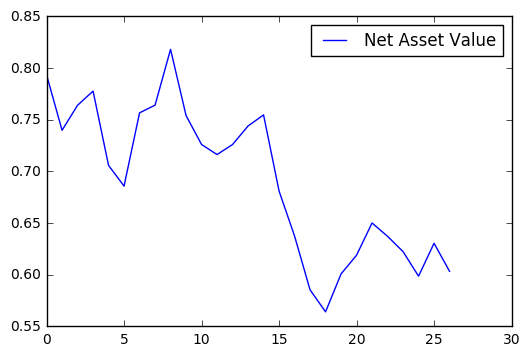

In [30]:
from performance_analysis.pa_core import *
pnl.columns = ['Date', 'Pnl']
# simple_pa(pnl)
pmfc = (cagr(pnl), vol(pnl), sharpe_ratio(pnl), max_drawdown(pnl), drawdown_length(pnl))
print('CAGR:%f \nVolatility:%f\nSharpe_ratio:%f\nmax drawdown: %f\ndrawdown length: %f\n' % pmfc)

plot_nav(pnl)